# 2-D Swift-Hohenberg with Continuation

This notebook simulates the 2-D Swift-Hohenberg equation, a standard model for pattern formation. A simple numerical continuation is performed by varying the bifurcation parameter $\epsilon$. For each value of $\epsilon$, the system is evolved to a steady state, with the final state of the previous simulation serving as the initial condition for the next.

The equation is:
$$
\partial_t u = \epsilon u - (1 + \nabla^2)^2 u - u^3
$$
on a periodic square domain.

We use a Fourier spectral discretization and semi-implicit time stepping.

In [1]:
import numpy as np
from numpy.fft import fft2, ifft2, fftfreq
import matplotlib.pyplot as plt

np.random.seed(42)
plt.rcParams.update({"figure.figsize": (6, 4), "image.cmap": "viridis"})

### Parameters
Define the physical and numerical parameters for the simulation:
- `N`: Grid resolution.
- `L`: Domain size.
- `dt`: Time step.
- `epsilons`: Range of the bifurcation parameter $\epsilon$ for continuation.

In [2]:
N = 128          # Grid resolution
L = 40.0         # Domain size
dt = 0.1         # Time step

steps_per_epsilon = 500
epsilons = np.linspace(-0.1, 0.5, 13) # Continuation parameter range

### Spatial grid and spectral operators
Set up the computational grid, wavenumbers, and a dealiasing mask for the spectral method.

In [3]:
x = np.linspace(0, L, N, endpoint=False)
X, Y = np.meshgrid(x, x, indexing="ij")

k = 2 * np.pi * fftfreq(N, d=L / N)
KX, KY = np.meshgrid(k, k, indexing="ij")
K2 = KX**2 + KY**2

# Dealiasing mask (2/3 rule)
k_cut = (2.0 / 3.0) * np.max(np.abs(k))
mask = (np.abs(KX) <= k_cut) & (np.abs(KY) <= k_cut)

### Helper functions
`dealiase`: Applies the dealiasing mask.
`free_energy`: Computes the Lyapunov functional (free energy) of the system.
`l2_norm`: Computes the L2 norm of the solution.
`step`: Performs a single time step using a semi-implicit Euler scheme.

In [4]:
def dealiase(hat_field):
    return hat_field * mask

def free_energy(u, epsilon):
    """
    Calculate the Lyapunov functional (free energy):
    F[u] = integral [ -epsilon/2 * u^2 + 1/2 * ((1 + del^2)u)^2 + 1/4 * u^4 ] dx
    """
    u_hat = fft2(u)
    
    # Term: (1 + del^2) u
    # In Fourier: (1 - k^2) u_hat
    linear_term_hat = (1 - K2) * u_hat
    linear_term = np.real(ifft2(linear_term_hat))
    
    # Integral approximation (mean * Volume, but here we usually work with densities or just mean)
    # Let's compute the mean density of the energy
    f_density = -0.5 * epsilon * u**2 + 0.5 * linear_term**2 + 0.25 * u**4
    return np.mean(f_density)

def l2_norm(u):
    return np.sqrt(np.mean(u**2))

def step(u, epsilon):
    """
    Semi-implicit Euler step:
    (u_new - u)/dt = (epsilon - (1 + del^2)^2) u_new - u^3
    => [1 - dt(epsilon - (1 + del^2)^2)] u_new = u - dt * u^3
    """
    u_hat = fft2(u)
    
    # Linear operator L = epsilon - (1 - K^2)^2
    L_linear = epsilon - (1 - K2)**2
    denom = 1.0 - dt * L_linear
    
    # Nonlinear term: u^3
    # Apply dealiasing to the nonlinear product
    nonlinear = u**3
    nonlinear_hat = fft2(nonlinear)
    nonlinear_hat = dealiase(nonlinear_hat)
    
    # Update
    # u_hat_new = (u_hat - dt * nonlinear_hat) / denom
    # Note: The equation is u_t = L u - u^3. 
    # Implicit linear: u_new - dt L u_new = u - dt u^3
    numer = u_hat - dt * nonlinear_hat
    u_hat_new = numer / denom
    
    return np.real(ifft2(u_hat_new))

### Initialization and Continuation Loop
Initialize the simulation with random noise and run the continuation loop. For each $\epsilon$, the system relaxes towards a steady state. The free energy and L2 norm are recorded.

In [5]:
# Start with small random noise
u = 0.1 * (np.random.rand(N, N) - 0.5)

energies = []
norms = []
fields = []
eps_history = []

# Continuation loop
print("Starting continuation...")
u_current = u.copy()

for eps in epsilons:
    # Relaxation
    for _ in range(steps_per_epsilon):
        u_current = step(u_current, eps)
    
    # Record diagnostics
    F = free_energy(u_current, eps)
    nm = l2_norm(u_current)
    
    energies.append(F)
    norms.append(nm)
    fields.append(u_current.copy())
    eps_history.append(eps)
    
    print(f"epsilon={eps:+.3f}  norm={nm:.4e}  F={F:.4e}")

Starting continuation...
epsilon=-0.100  norm=7.1008e-06  F=2.6127e-12
epsilon=-0.050  norm=5.1812e-07  F=6.9409e-15
epsilon=-0.000  norm=4.8677e-07  F=1.0473e-16
epsilon=+0.050  norm=5.7726e-06  F=-8.2497e-13
epsilon=+0.100  norm=8.6173e-04  F=-3.7016e-08
epsilon=+0.150  norm=2.5357e-01  F=-2.4217e-03
epsilon=+0.200  norm=3.3787e-01  F=-5.6007e-03
epsilon=+0.250  norm=4.0763e-01  F=-1.0343e-02
epsilon=+0.300  norm=4.4717e-01  F=-1.4965e-02
epsilon=+0.350  norm=4.8324e-01  F=-2.0402e-02
epsilon=+0.400  norm=5.1676e-01  F=-2.6671e-02
epsilon=+0.450  norm=5.4823e-01  F=-3.3773e-02
epsilon=+0.500  norm=5.7798e-01  F=-4.1709e-02


### Visualization of Patterns
Visualize snapshots of the steady-state patterns at different values of $\epsilon$.

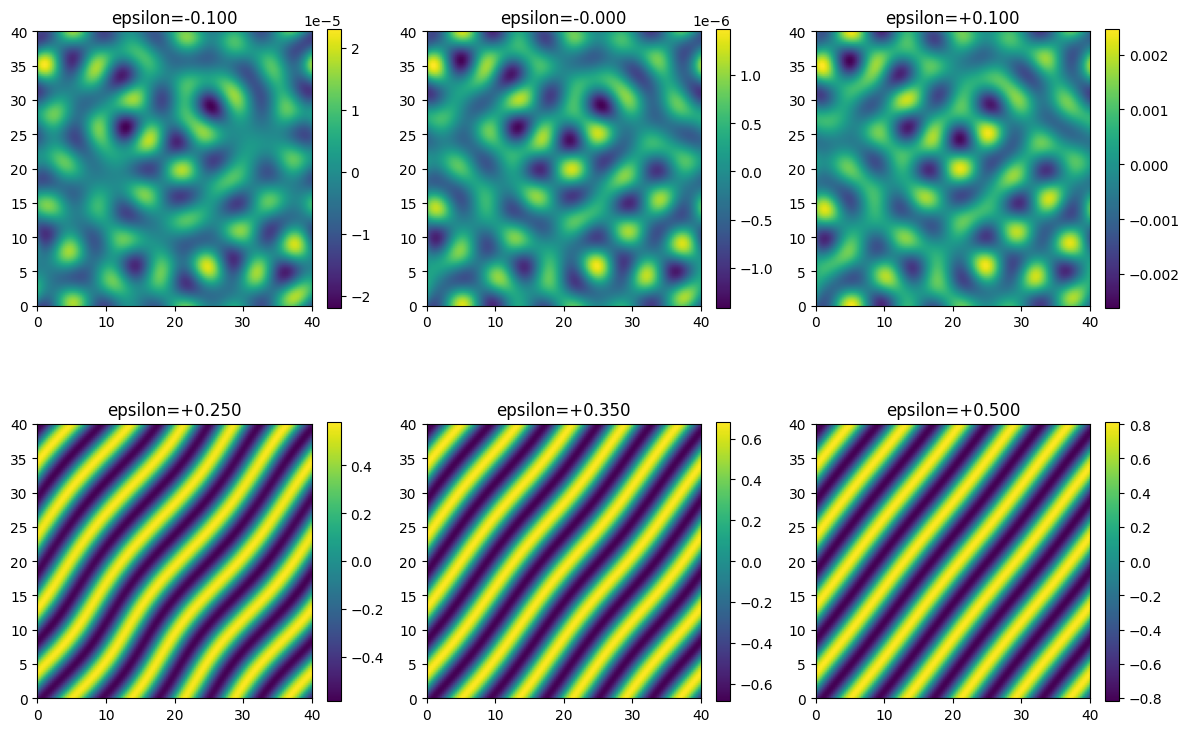

In [6]:
n_snap = min(6, len(fields))
snap_indices = np.linspace(0, len(fields) - 1, n_snap, dtype=int)

cols = 3
rows = int(np.ceil(n_snap / cols))
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 4 * rows))
axes = np.array(axes).reshape(-1)

for ax, idx in zip(axes, snap_indices):
    im = ax.imshow(fields[idx], origin="lower", extent=(0, L, 0, L))
    ax.set_title(f"epsilon={eps_history[idx]:+.3f}")
    fig.colorbar(im, ax=ax, fraction=0.046)

for ax in axes[len(snap_indices):]:
    ax.axis("off")

fig.tight_layout()
plt.show()

### Bifurcation Diagram
Plot the bifurcation diagrams for amplitude (L2 norm) and energy. This shows the onset of pattern formation as $\epsilon$ increases.

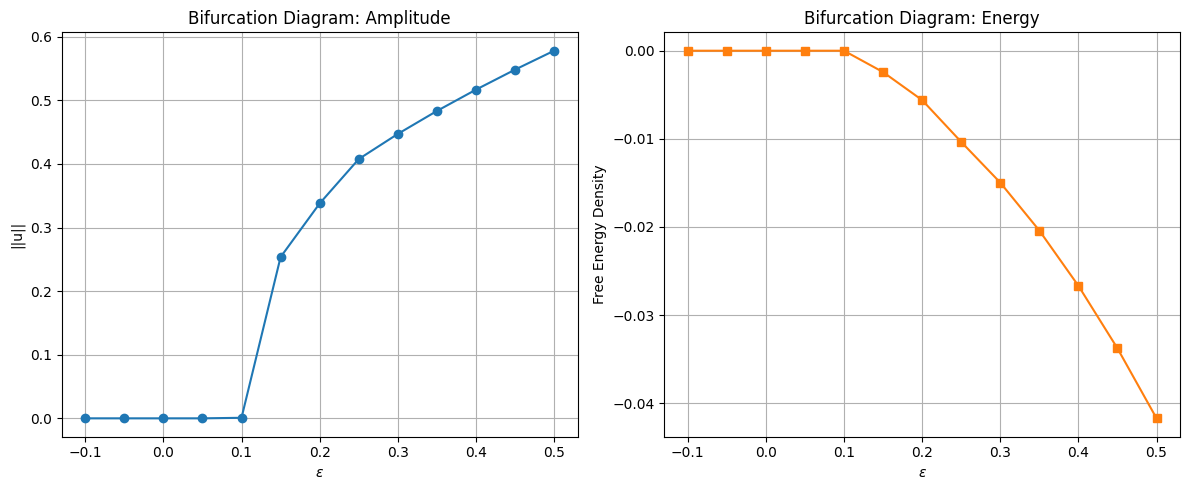

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Norm vs Epsilon
ax[0].plot(eps_history, norms, "o-", label="L2 Norm")
ax[0].set_xlabel(r"$\epsilon$")
ax[0].set_ylabel("||u||")
ax[0].set_title("Bifurcation Diagram: Amplitude")
ax[0].grid(True)

# Free Energy vs Epsilon
ax[1].plot(eps_history, energies, "s-", color="tab:orange", label="Free Energy")
ax[1].set_xlabel(r"$\epsilon$")
ax[1].set_ylabel("Free Energy Density")
ax[1].set_title("Bifurcation Diagram: Energy")
ax[1].grid(True)

plt.tight_layout()
plt.show()